数据加载完成，共 1641 条记录。
类别分布：
Label
Vascular Dementia          350
Alzheimer's Disease        339
Parkinson's Disease        338
Lewy Body Dementia         319
Frontotemporal Dementia    295
Name: count, dtype: int64

词汇表大小: 9031

--- 10-Fold Cross-Validation Results ---
平均准确率: 0.6990 (+/- 0.0642)

--- Test Set Evaluation ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.68      0.57      0.62        68
Frontotemporal Dementia       0.80      0.75      0.77        59
     Lewy Body Dementia       0.60      0.66      0.63        64
    Parkinson's Disease       0.69      0.60      0.65        68
      Vascular Dementia       0.62      0.79      0.70        70

               accuracy                           0.67       329
              macro avg       0.68      0.67      0.67       329
           weighted avg       0.68      0.67      0.67       329



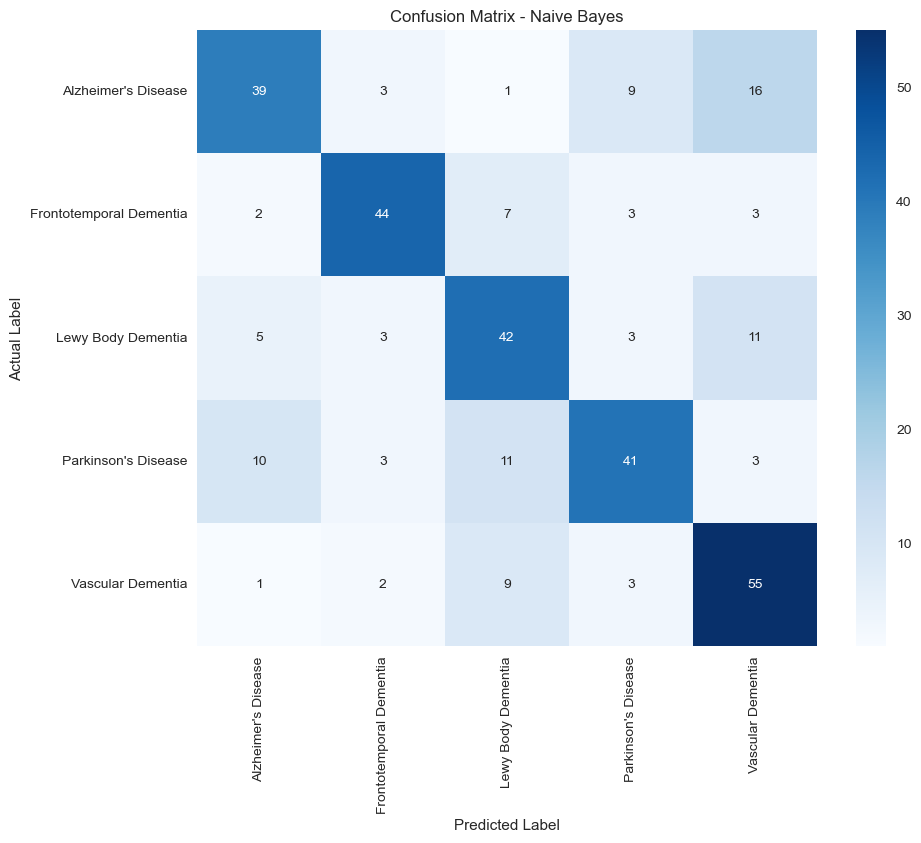

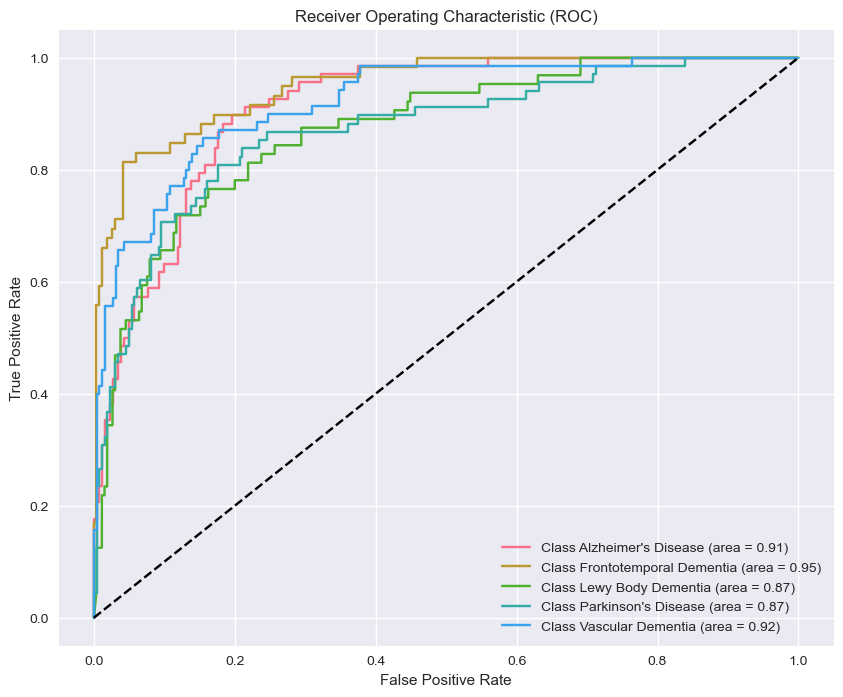

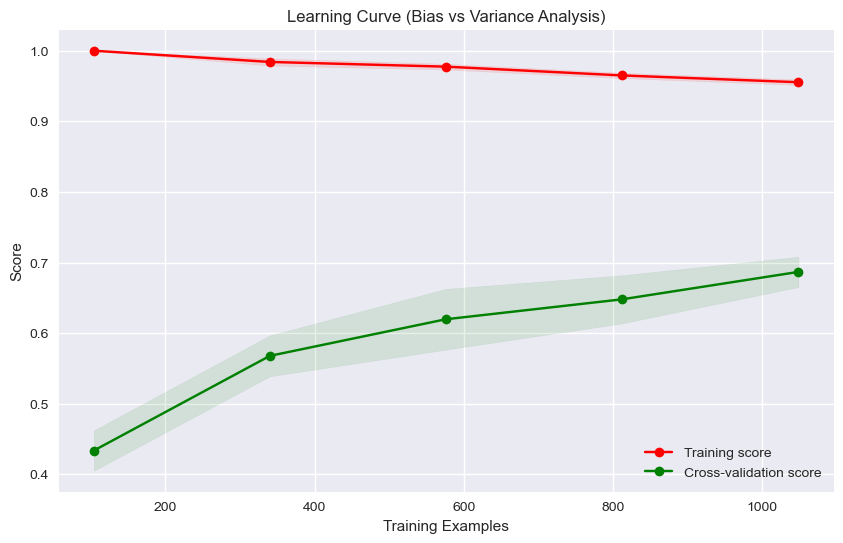


--- Error Analysis (Sample Misclassifications) ---
共发现 108 个错误分类样本。以下是前 3 个：
               True_Label            Predicted  \
99    Alzheimer's Disease    Vascular Dementia   
1056  Parkinson's Disease  Alzheimer's Disease   
1241  Parkinson's Disease    Vascular Dementia   

                                                   Text  
99    objective increasing focus [DISEASE] [DISEASE]...  
1056  post covid condition represent medical challen...  
1241  system online embase excerpta medica database ...  

--- Explainability: Top Keywords per Class ---
[Alzheimer's Disease]: ['amyloid', 'result', 'cell', 'inf', 'brain', 'cognitive', 'model', 'study', 'tau', 'disease']
[Frontotemporal Dementia]: ['ftld', 'group', 'variant', 'protein', 'al', 'mutation', 'tau', 'study', 'patient', 'disease']
[Lewy Body Dementia]: ['age', 'clinical', 'diagnosis', 'synuclein', 'brain', 'study', 'cognitive', 'body', 'patient', 'disease']
[Parkinson's Disease]: ['brain', 'result', 'method', 'analysis', 'using

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import shap
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 数据加载与预处理
# ==========================================
print("Step 1: Loading Data...")
try:
    df = pd.read_csv('../cleaned_data.csv')
except:
    df = pd.read_csv('cleaned_data.csv')

df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])
label_names = le.classes_
print(f"Classes: {label_names}")

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label_Encoded'], 
    test_size=0.2, random_state=42, stratify=df['Label_Encoded']
)

# ==========================================
# 2. 特征工程: BoW (CountVectorizer)
# ==========================================
print("Step 2: Extracting BoW Features...")
vectorizer = CountVectorizer(max_features=5000, stop_words='english')

X_train_features = vectorizer.fit_transform(X_train_raw)
X_test_features = vectorizer.transform(X_test_raw)
feature_names = vectorizer.get_feature_names_out()

print(f"Feature Matrix Shape: {X_train_features.shape}")

# ==========================================
# 3. 模型训练: Multinomial Naive Bayes
# ==========================================
print("\nStep 3: Training MultinomialNB...")
nb_model = MultinomialNB()

print("Running 10-Fold Cross-Validation...")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(nb_model, X_train_features, y_train, cv=cv, scoring='accuracy')

print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

nb_model.fit(X_train_features, y_train)

# ==========================================
# 4. 学习曲线
# ==========================================
print("\nStep 4: Plotting Learning Curves...")
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(nb_model, "Learning Curve (Naive Bayes)", X_train_features, y_train, cv=cv, n_jobs=-1)

# ==========================================
# 5. 评估与可视化
# ==========================================
y_pred = nb_model.predict(X_test_features)
y_prob = nb_model.predict_proba(X_test_features)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=label_names))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 6))
y_test_bin = pd.get_dummies(y_test).values
if y_test_bin.shape[1] == len(label_names):
    for i, class_label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# ==========================================
# 6. 误差分析
# ==========================================
print("\nStep 6: Error Analysis...")
misclassified_indices = np.where(y_test != y_pred)[0]
# ... Standard Code ...
if len(misclassified_indices) > 0:
    error_docs = X_test_raw.iloc[misclassified_indices]
    from sklearn.feature_extraction.text import CountVectorizer
    error_cv = CountVectorizer(stop_words='english', max_features=20)
    try:
        error_counts = error_cv.fit_transform(error_docs)
        error_words = error_cv.get_feature_names_out()
        error_word_freq = np.asarray(error_counts.sum(axis=0)).flatten()
        print(f"Top Words in Errors: {sorted(dict(zip(error_words, error_word_freq)).items(), key=lambda x: x[1], reverse=True)}")
    except: pass

# ==========================================
# 7. 可解释性 (NB Specific: Top Keywords)
# ==========================================
print("\nStep 7: NB Interpretability...")
# Print most indicative words per class
log_prob = nb_model.feature_log_prob_
for i, class_name in enumerate(label_names):
    top10_indices = log_prob[i].argsort()[::-1][:10]
    top10_words = feature_names[top10_indices]
    print(f"Top 10 words for {class_name}: {', '.join(top10_words)}")
